# 9장 다중 분류 (Mulitnomial classification)

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [6]:
# 파이토치 관련 라이브러리
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchviz import make_dot
from torchinfo import summary

# Iris dataset
import pandas  as pd
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [7]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [8]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

## Iris data

### 데이터 불러오기

In [15]:
# 학습용 데이터 준비

# 라이브러리 임포트
# from sklearn.datasets import load_iris

# 데이터 불러오기
iris = load_iris()
print("iris = \n", iris)
print('iris keys = \n', iris.keys())
print("target_names = \n", iris["target_names"])

iris = 
 {'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.

In [20]:
# 입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

# 결과 확인
print('원본 데이터 타입 :', type(x_org), type(y_org))
print('원본 데이터 크기 :', x_org.shape, y_org.shape)

원본 데이터 타입 : <class 'numpy.ndarray'> <class 'numpy.ndarray'>
원본 데이터 크기 : (150, 4) (150,)


### 데이터 추출

In [22]:
# 입력 데이터로 sepal(꽃받침) length(0)와 petal(꽃잎) length(2)를 추출
x_select = x_org[:,[0,2]]

# 결과 확인
print('원본 데이터', x_select.shape, y_org.shape)

원본 데이터 (150, 2) (150,)


### 훈련 데이터와 검증 데이터 분할

In [28]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75, 
    random_state=123)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


### 훈련 데이터의 산포도 출력

In [29]:
# 데이터를 정답별로 분할

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

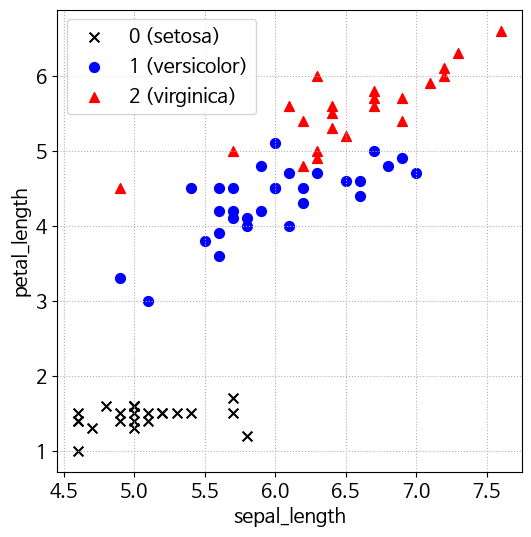

In [30]:
# 산포도 출력

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolor)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='^', c='r', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

### 모델 정의

In [37]:
# 학습용 파라미터 설정

# 입력 차원수
n_input = x_train.shape[1]

# 출력 차원수
# 분류 클래스 수, 여기서는 3
n_output = len(list(set(y_train)))

# 결과 확인
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [38]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# 인스턴스 생성
net = Net(n_input, n_output)
# list(net.parameters())

### 모델 확인

In [39]:
# 모델 내부 파라미터 확인
# l1.weight는 행렬, l1.bias는 벡터

for parameter in net.named_parameters():
    print(parameter)


('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [40]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [45]:
# 모델 개요 표시 2

summary(net, (2,), device = 'cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       9
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 최적화 알고리즘과 손실 함수의 정의

In [46]:
# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

### 경사 하강법

In [47]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long() 

# 검증 데이터의 텐서 변수화

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

### 손실의 계산 그래프 시각화

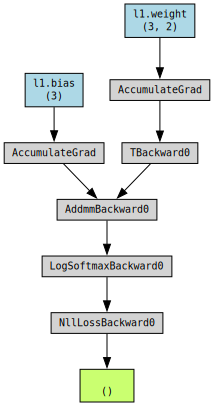

In [49]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실의 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 예측 라벨을 얻는 방법

In [50]:
# torch.max 함수 호출
# 2번째 인수는 축을 의미함. 1이면 행별로 집계
print(torch.max(outputs, 1))
# print(torch.argmax(outputs, 1))

# 예측 라벨 리스트를 취득
torch.max(outputs, 1)[1]

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

### 반복 계산

In [51]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [52]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):

    # 훈련 페이즈
    
    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ((epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631, val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740, val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85500, val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815, val_acc: 0.62667
Epoch [120/10000], loss: 0.

### 결과 확인

In [53]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09263  정확도 : 0.26667
최종상태 : 손실 : 0.19795  정확도 : 0.96000


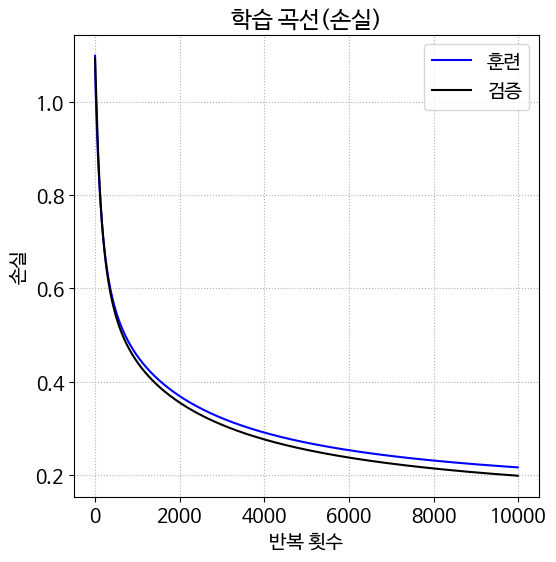

In [54]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

### 모델 출력 확인

In [55]:
# 정답 데이터의 0번째, 2번째, 3번째를 추출

print(labels[[0,2,3]])

# 이에 해당하는 입력값을 추출
print("="*50)
i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

tensor([1, 0, 2])
[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [56]:
# 출력값에 소프트맥스 함수를 적용한 결과를 취득

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.8071 14.1938 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


### 가중치 행렬과 바이어스 값

In [58]:
# 가중치 행렬
print(net.l1.weight.data)

# 바이어스
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


### 입력 변수 4개 사용하기

In [59]:
# 훈련 데이터와 검증 데이터로 분할(셔플도 동시에 실시함)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 입력 차원수
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [60]:
print('입력 데이터(x)')
print(x_train[:5,:])
print(f'입력 차원수: {n_input}')

입력 데이터(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
입력 차원수: 4


In [61]:
# 입력 데이터 x_train과 정답 데이터 y_train의 텐서 변수화
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 검증용 데이터의 텐서 변수화
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [62]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [63]:
for epoch in range(num_epochs):

    # 훈련 페이즈
    
    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [64]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.13724  정확도 : 0.96000


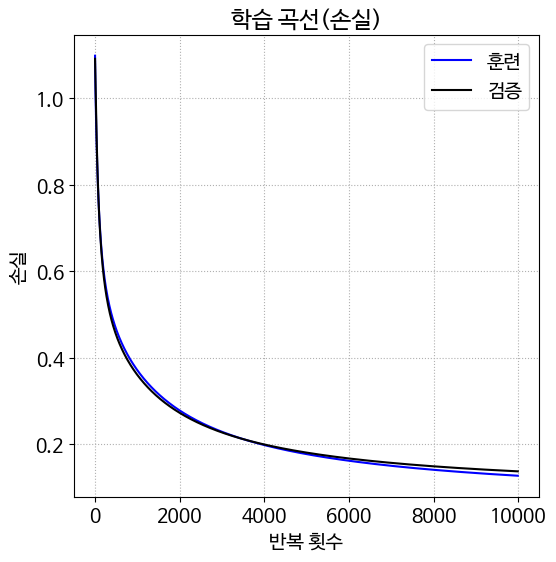

In [65]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

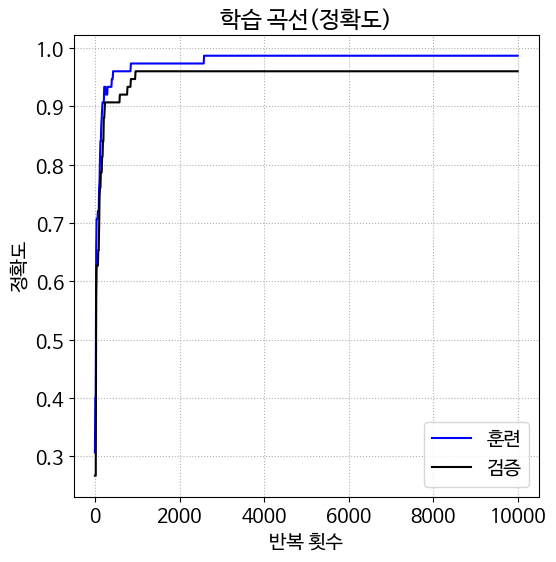

In [68]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### NLLLoss 함수 이해 하기

In [69]:
# 입력 변수 준비

# 더미 출력 데이터
outputs_np = np.array(range(1, 13)).reshape((4,3))
# 더미 정답 데이터
labels_np = np.array([0, 1, 2, 0])

# 텐서화
outputs_dummy = torch.tensor(outputs_np).float()
labels_dummy = torch.tensor(labels_np).long()

# 결과 확인
print(outputs_dummy.data)
print(labels_dummy.data)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([0, 1, 2, 0])


In [127]:
# NLLLoss 함수 호출

nllloss = nn.NLLLoss()
loss = nllloss(outputs_dummy, labels_dummy) # -(1 + 5 + 9 + 10)/4 = -6.25
print(loss.item())

-6.25


### 모델 클래스측에 LogSoftmax 함수를 포함

In [70]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # logsoftmax 함수 정의
        self.logsoftmax = nn.LogSoftmax(dim=1)
                
        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적        
        # self.l1.weight.data.fill_(1.0)
        # self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.logsoftmax(x1)
        return x2

In [71]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

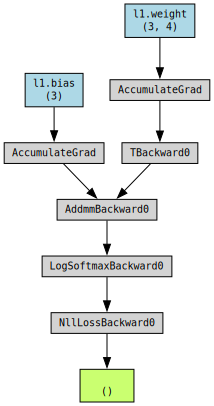

In [72]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실의 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [73]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [74]:
for epoch in range(num_epochs):

    # 훈련 페이즈
    
    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)

    # 손실 계산
    loss_test = criterion(outputs_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.74435 acc: 0.32000 val_loss: 1.89647, val_acc: 0.57333
Epoch [10/10000], loss: 1.04036 acc: 0.62667 val_loss: 1.09881, val_acc: 0.49333
Epoch [20/10000], loss: 0.93898 acc: 0.66667 val_loss: 0.96434, val_acc: 0.54667
Epoch [30/10000], loss: 0.89766 acc: 0.70667 val_loss: 0.91556, val_acc: 0.61333
Epoch [40/10000], loss: 0.86195 acc: 0.70667 val_loss: 0.87572, val_acc: 0.61333
Epoch [50/10000], loss: 0.83032 acc: 0.70667 val_loss: 0.84063, val_acc: 0.62667
Epoch [60/10000], loss: 0.80220 acc: 0.70667 val_loss: 0.80956, val_acc: 0.62667
Epoch [70/10000], loss: 0.77712 acc: 0.72000 val_loss: 0.78195, val_acc: 0.62667
Epoch [80/10000], loss: 0.75465 acc: 0.72000 val_loss: 0.75730, val_acc: 0.62667
Epoch [90/10000], loss: 0.73444 acc: 0.74667 val_loss: 0.73522, val_acc: 0.62667
Epoch [100/10000], loss: 0.71617 acc: 0.74667 val_loss: 0.71533, val_acc: 0.65333
Epoch [110/10000], loss: 0.69959 acc: 0.76000 val_loss: 0.69733, val_acc: 0.69333
Epoch [120/10000], loss: 0.

In [75]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.89647  정확도 : 0.57333
최종상태 : 손실 : 0.13736  정확도 : 0.96000


In [76]:
# 패턴 2 모델의 출력 결과
w = outputs[:5,:].data
print(w.numpy())

# 확률값을 얻고 싶은 경우
print(torch.exp(w).numpy())

[[ -5.0296  -0.1004  -2.4189]
 [ -4.8426  -0.022   -4.2776]
 [ -0.0583  -2.8716 -16.2088]
 [-11.7034  -3.2038  -0.0415]
 [ -9.1574  -1.7262  -0.1961]]
[[0.0065 0.9044 0.089 ]
 [0.0079 0.9782 0.0139]
 [0.9434 0.0566 0.    ]
 [0.     0.0406 0.9594]
 [0.0001 0.178  0.8219]]


### 모델 클래스측에 소프트맥스 함수 만 포함된 경우

In [78]:
# 모델 정의
# 2입력 3출력 로지스틱 회귀 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # 소프트맥스 함수 정의
        self.softmax = nn.Softmax(dim=1)
                
        # 초깃값을 모두 1로 함
        # "딥러닝을 위한 수학"과 조건을 맞추기 위한 목적        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [79]:
# 학습률
lr = 0.01

# 초기화
net = Net(n_input, n_output)

# 손실 함수： NLLLoss 함수
criterion = nn.NLLLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10000

# 평가 결과 기록
history = np.zeros((0,5))

In [80]:
for epoch in range(num_epochs):

    # 훈련 페이즈
    
    # 경사 초기화
    optimizer.zero_grad()

    # 예측 계산
    outputs = net(inputs)
    
    # 여기서 로그 함수를 적용함
    outputs2 = torch.log(outputs)

    # 손실 계산
    loss = criterion(outputs2, labels)

    # 경사 계산
    loss.backward()
    
    # 파라미터 수정
    optimizer.step()

    # 예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    # 손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    # 예측 페이즈

    # 예측 계산
    outputs_test = net(inputs_test)
        
    # 여기서 로그 함수를 적용함
    outputs2_test = torch.log(outputs_test)

    # 손실 계산
    loss_test = criterion(outputs2_test, labels_test)

    # 예측 라벨 산출
    predicted_test = torch.max(outputs_test, 1)[1]

    # 손실과 정확도 계산
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

In [81]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.09158  정확도 : 0.26667
최종상태 : 손실 : 0.13724  정확도 : 0.96000


In [82]:
# 패턴 3 모델의 출력값
w = outputs[:5,:].data.numpy()
print(w)

[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]
